## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import BertDataset
from bert import CustomBert3
from ranker_models import TransformerRanker
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, MixedLoss, SpearmanLoss
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [ ]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 32.6 s, sys: 220 ms, total: 32.8 s
Wall time: 33.1 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 64

In [8]:
bs_test = 2
# test_loader = DataLoader(
#     TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
#                 seg_ids_test['question'], seg_ids_test['answer'], test.index),
#     batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
# )

## Training model

In [9]:
lr = 1e-4
device = 'cuda'
n_epochs = 10
grad_accum = 1
weight_decay = 0.1
bert_output_dir = 'bert_output/'
pretrained_model = 'siamese_bert_5'
model_name = 'siamese_bert_6'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
class MixedLoss(nn.Module):
    def __init__(self, rank_net):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.l1 = nn.L1Loss()
        self.spl = SpearmanLoss(rank_net)

    def forward(self, input, target):
        loss = (
             1.0 * self.bce(input, target) 
            + 1.0 * self.l1(torch.sigmoid(input), target) 
            + 1.0 * self.spl(torch.sigmoid(input), target)
        )
        return loss

In [11]:
rank_net = TransformerRanker(dim=512, bs=bs, n_heads=8, n_layers=6)
checkpoint = torch.load(f'{checkpoint_dir}ranker_transformer_bs{bs}_best.pth')
rank_net.load_state_dict(checkpoint['model_state_dict'])
rank_net.to(device)
loss_fn = MixedLoss(rank_net)

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(get_optimizer_param_groups(model, lr, weight_decay))

def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomBert3(256, cat_features_train.shape[1])
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.head

Fold 1 started at Mon Jan 20 22:23:54 2020


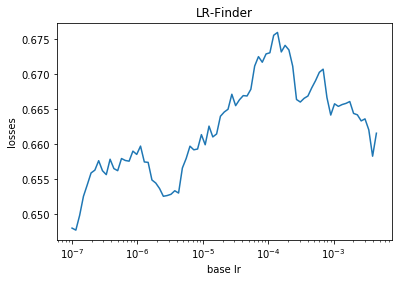

epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.74012 - spearmanr 0.41749
best model: epoch -1 - 0.41749
epoch 0: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 0/10 	 train : loss 0.66084 - spearmanr 0.51461
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.73679 - spearmanr 0.42019
best model: epoch 0 - 0.42019
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.65542 - spearmanr 0.51799
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.73698 - spearmanr 0.42095
best model: epoch 1 - 0.42095
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.65392 - spearmanr 0.51836
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.73715 - spearmanr 0.42032
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.65183 - spearmanr 0.51904
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.73675 - spearmanr 0.42031
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.65027 - spearmanr 0.52012
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.73672 - spearmanr 0.42092
model not improved for 3 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64835 - spearmanr 0.52214
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.73713 - spearmanr 0.42051
model not improved for 4 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.64707 - spearmanr 0.52273
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.73698 - spearmanr 0.4204
model not improved for 5 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.64527 - spearmanr 0.52423
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.73829 - spearmanr 0.4203
model not improved for 6 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.64505 - spearmanr 0.52382
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.73805 - spearmanr 0.42023
model not improved for 7 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.64383 - spearmanr 0.52469
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.7374 - spearmanr 0.4204
model not improved for 8 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42095
Starting inference for model: checkpoints/siamese_bert_6_fold_1_best.pth



Fold 2 started at Mon Jan 20 22:25:00 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.74269 - spearmanr 0.42238
best model: epoch -1 - 0.42238
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.65853 - spearmanr 0.51774
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.73744 - spearmanr 0.42437
best model: epoch 0 - 0.42437
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.65283 - spearmanr 0.5194
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.73748 - spearmanr 0.42499
best model: epoch 1 - 0.42499
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.65004 - spearmanr 0.52126
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.73784 - spearmanr 0.42464
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.64864 - spearmanr 0.52158
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.73748 - spearmanr 0.42479
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.64644 - spearmanr 0.52329
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.73753 - spearmanr 0.42397
model not improved for 3 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64487 - spearmanr 0.52407
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.73724 - spearmanr 0.42384
model not improved for 4 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.64427 - spearmanr 0.52396
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.73831 - spearmanr 0.42219
model not improved for 5 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.64292 - spearmanr 0.52542
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.73842 - spearmanr 0.42202
model not improved for 6 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.64227 - spearmanr 0.52516
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.73815 - spearmanr 0.4222
model not improved for 7 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.64141 - spearmanr 0.52651
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.73823 - spearmanr 0.42185
model not improved for 8 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42499
Starting inference for model: checkpoints/siamese_bert_6_fold_2_best.pth



Fold 3 started at Mon Jan 20 22:26:02 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.75324 - spearmanr 0.39437
best model: epoch -1 - 0.39437
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.65166 - spearmanr 0.52202
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.74799 - spearmanr 0.39813
best model: epoch 0 - 0.39813
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.64739 - spearmanr 0.52475
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.74832 - spearmanr 0.3987
best model: epoch 1 - 0.3987
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.64495 - spearmanr 0.52627
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.74851 - spearmanr 0.39873
best model: epoch 2 - 0.39873
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.64301 - spearmanr 0.5277
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.74835 - spearmanr 0.3986
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.64176 - spearmanr 0.52879
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.74853 - spearmanr 0.39861
model not improved for 2 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64045 - spearmanr 0.52941
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.74827 - spearmanr 0.39846
model not improved for 3 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.63917 - spearmanr 0.53034
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.74894 - spearmanr 0.39748
model not improved for 4 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.63815 - spearmanr 0.53144
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.74894 - spearmanr 0.39744
model not improved for 5 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.63711 - spearmanr 0.53274
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.74985 - spearmanr 0.39662
model not improved for 6 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.63573 - spearmanr 0.53403
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.74934 - spearmanr 0.39744
model not improved for 7 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39873
Starting inference for model: checkpoints/siamese_bert_6_fold_3_best.pth



Fold 4 started at Mon Jan 20 22:27:03 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.74392 - spearmanr 0.39795
best model: epoch -1 - 0.39795
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.6551 - spearmanr 0.52017
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.742 - spearmanr 0.39762
model not improved for 1 epochs
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.65098 - spearmanr 0.52216
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.74187 - spearmanr 0.39787
model not improved for 2 epochs
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.64847 - spearmanr 0.52421
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.74199 - spearmanr 0.39739
model not improved for 3 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.64694 - spearmanr 0.52486
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.74224 - spearmanr 0.3969
model not improved for 4 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.64543 - spearmanr 0.52587
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.7426 - spearmanr 0.39561
model not improved for 5 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64376 - spearmanr 0.52726
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.74262 - spearmanr 0.39563
model not improved for 6 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.64271 - spearmanr 0.52773
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.74337 - spearmanr 0.39461
model not improved for 7 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.64129 - spearmanr 0.52901
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.74321 - spearmanr 0.39566
model not improved for 8 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.64053 - spearmanr 0.52982
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.74282 - spearmanr 0.39638
model not improved for 9 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.63977 - spearmanr 0.53069
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.74309 - spearmanr 0.39611
model not improved for 10 epochs
TRAINING END: Best score achieved on epoch -1 - 0.39795
Starting inference for model: checkpoints/siamese_bert_6_fold_4_best.pth



Fold 5 started at Mon Jan 20 22:28:04 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.73687 - spearmanr 0.40351
best model: epoch -1 - 0.40351
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.65524 - spearmanr 0.51926
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.73349 - spearmanr 0.40575
best model: epoch 0 - 0.40575
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.65101 - spearmanr 0.52218
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.73431 - spearmanr 0.40561
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.64864 - spearmanr 0.52307
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.7347 - spearmanr 0.40564
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.64685 - spearmanr 0.52348
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.73522 - spearmanr 0.40523
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.64456 - spearmanr 0.52541
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.73518 - spearmanr 0.40426
model not improved for 4 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64358 - spearmanr 0.52597
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.73595 - spearmanr 0.40354
model not improved for 5 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.64245 - spearmanr 0.52761
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.7369 - spearmanr 0.40281
model not improved for 6 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.64089 - spearmanr 0.52875
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.73693 - spearmanr 0.40225
model not improved for 7 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.64008 - spearmanr 0.52971
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.73704 - spearmanr 0.40351
model not improved for 8 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.63958 - spearmanr 0.5295
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.73701 - spearmanr 0.40321
model not improved for 9 epochs
TRAINING END: Best score achieved on epoch 0 - 0.40575
Starting inference for model: checkpoints/siamese_bert_6_fold_5_best.pth



Fold 6 started at Mon Jan 20 22:29:05 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.74199 - spearmanr 0.39518
best model: epoch -1 - 0.39518
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.63539 - spearmanr 0.54149
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.74087 - spearmanr 0.39543
best model: epoch 0 - 0.39543
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.63312 - spearmanr 0.54283
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.7414 - spearmanr 0.39599
best model: epoch 1 - 0.39599
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.63065 - spearmanr 0.54446
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.74244 - spearmanr 0.3947
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.62993 - spearmanr 0.54473
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.7432 - spearmanr 0.39413
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.62779 - spearmanr 0.54551
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.74378 - spearmanr 0.39379
model not improved for 3 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.62682 - spearmanr 0.54595
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.74417 - spearmanr 0.39378
model not improved for 4 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.62585 - spearmanr 0.54695
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.74432 - spearmanr 0.39333
model not improved for 5 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.62533 - spearmanr 0.54694
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.7446 - spearmanr 0.39286
model not improved for 6 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.62418 - spearmanr 0.54899
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.74435 - spearmanr 0.39372
model not improved for 7 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.62278 - spearmanr 0.54961
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.74481 - spearmanr 0.39278
model not improved for 8 epochs
TRAINING END: Best score achieved on epoch 1 - 0.39599
Starting inference for model: checkpoints/siamese_bert_6_fold_6_best.pth



Fold 7 started at Mon Jan 20 22:30:06 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.74423 - spearmanr 0.41326
best model: epoch -1 - 0.41326
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.65394 - spearmanr 0.52073
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.74271 - spearmanr 0.41504
best model: epoch 0 - 0.41504
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.64944 - spearmanr 0.52303
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.74237 - spearmanr 0.41592
best model: epoch 1 - 0.41592
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.64781 - spearmanr 0.52321
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.74334 - spearmanr 0.41463
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.64594 - spearmanr 0.52471
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.74318 - spearmanr 0.41495
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.64466 - spearmanr 0.52507
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.74244 - spearmanr 0.41483
model not improved for 3 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64357 - spearmanr 0.52623
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.74284 - spearmanr 0.41444
model not improved for 4 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.64226 - spearmanr 0.52643
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.7429 - spearmanr 0.4147
model not improved for 5 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.64096 - spearmanr 0.52819
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.7436 - spearmanr 0.4145
model not improved for 6 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.63941 - spearmanr 0.52949
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.74375 - spearmanr 0.41445
model not improved for 7 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.63827 - spearmanr 0.53061
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.74384 - spearmanr 0.41486
model not improved for 8 epochs
TRAINING END: Best score achieved on epoch 1 - 0.41592
Starting inference for model: checkpoints/siamese_bert_6_fold_7_best.pth



Fold 8 started at Mon Jan 20 22:31:07 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.74704 - spearmanr 0.41653
best model: epoch -1 - 0.41653
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.65456 - spearmanr 0.52015
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.74476 - spearmanr 0.41727
best model: epoch 0 - 0.41727
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.64997 - spearmanr 0.52234
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.74543 - spearmanr 0.41647
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.64755 - spearmanr 0.52396
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.74572 - spearmanr 0.41635
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.64622 - spearmanr 0.52483
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.74553 - spearmanr 0.41699
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.64372 - spearmanr 0.52634
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.74623 - spearmanr 0.41673
model not improved for 4 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.64217 - spearmanr 0.52714
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.74635 - spearmanr 0.41732
best model: epoch 5 - 0.41732
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.64146 - spearmanr 0.52766
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.74596 - spearmanr 0.41746
best model: epoch 6 - 0.41746
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.64108 - spearmanr 0.52817
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.74601 - spearmanr 0.41815
best model: epoch 7 - 0.41815
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.6388 - spearmanr 0.53021
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.74568 - spearmanr 0.41818
best model: epoch 8 - 0.41818
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.63852 - spearmanr 0.53058
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.74567 - spearmanr 0.41769
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 8 - 0.41818
Starting inference for model: checkpoints/siamese_bert_6_fold_8_best.pth



Fold 9 started at Mon Jan 20 22:32:08 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.7382 - spearmanr 0.40505
best model: epoch -1 - 0.40505
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.63643 - spearmanr 0.53879
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.73724 - spearmanr 0.40522
best model: epoch 0 - 0.40522
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.63372 - spearmanr 0.53992
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.73802 - spearmanr 0.40551
best model: epoch 1 - 0.40551
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.63173 - spearmanr 0.54134
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.73836 - spearmanr 0.40487
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.62972 - spearmanr 0.54276
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.73946 - spearmanr 0.40435
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.62889 - spearmanr 0.54274
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.73952 - spearmanr 0.40444
model not improved for 3 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.62744 - spearmanr 0.54373
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.73983 - spearmanr 0.40347
model not improved for 4 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.62628 - spearmanr 0.54501
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.74085 - spearmanr 0.40229
model not improved for 5 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.6261 - spearmanr 0.5446
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.74107 - spearmanr 0.40208
model not improved for 6 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.62541 - spearmanr 0.54587
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.74082 - spearmanr 0.40238
model not improved for 7 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.6253 - spearmanr 0.54566
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.74167 - spearmanr 0.40204
model not improved for 8 epochs
TRAINING END: Best score achieved on epoch 1 - 0.40551
Starting inference for model: checkpoints/siamese_bert_6_fold_9_best.pth



Fold 10 started at Mon Jan 20 22:33:09 2020
epoch -1: 	 Start validation...



epoch -1/10 	 valid : loss 0.72606 - spearmanr 0.41975
best model: epoch -1 - 0.41975
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.63719 - spearmanr 0.53905
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.72421 - spearmanr 0.42084
best model: epoch 0 - 0.42084
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.63488 - spearmanr 0.53947
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.7244 - spearmanr 0.42083
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.63292 - spearmanr 0.54047
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.72441 - spearmanr 0.4211
best model: epoch 2 - 0.4211
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.63178 - spearmanr 0.54131
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.72497 - spearmanr 0.42021
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.63061 - spearmanr 0.5418
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.7253 - spearmanr 0.41994
model not improved for 2 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.6295 - spearmanr 0.5429
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.72485 - spearmanr 0.42038
model not improved for 3 epochs
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.62895 - spearmanr 0.54304
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.72511 - spearmanr 0.42015
model not improved for 4 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.62751 - spearmanr 0.54412
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.72533 - spearmanr 0.41991
model not improved for 5 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.62688 - spearmanr 0.5445
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.72556 - spearmanr 0.41901
model not improved for 6 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.62609 - spearmanr 0.5458
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.72571 - spearmanr 0.41919
model not improved for 7 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42110
Starting inference for model: checkpoints/siamese_bert_6_fold_10_best.pth



OOF score: 0.4107528438378178


In [13]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    
    output_file_path = lambda mode: f'{bert_output_dir}{mode}_{pretrained_model}_fold_{fold_id+1}'
    train_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('train')}_q_outputs.npy"),
                    np.load(f"{output_file_path('train')}_a_outputs.npy"), train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('valid')}_q_outputs.npy"),
                    np.load(f"{output_file_path('valid')}_a_outputs.npy"), valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = get_model(fold_id)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-7, 
                             end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=optim.lr_scheduler.StepLR(optimizer, n_epochs, 0.5), 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=False,
        eval_at_start=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
#     test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
#     preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [14]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

def ahmet_round(preds, ds, indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

In [15]:
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.36285628002905296
0 10 0.3764345841783075
0 15 0.37892366889014145
0 20 0.3794444437681643
0 33 0.38067879389763865
0 None 0.3811772506605218
1 5 0.6468432597286216
1 10 0.6614581706082987
1 15 0.6625118112034971
1 20 0.6644105534260489
1 33 0.6647957179592232
1 None 0.6649193943329073
2 5 0.47298244946698875
2 10 0.4879167590079496
3 5 0.2747303940545001
3 10 0.29048242775016425
3 15 0.29678758956963575
3 33 0.2982781912547178
4 5 0.3510049164263524
4 10 0.3524716374116788
4 15 0.35652549966068364
4 20 0.35755912847266724
4 None 0.35779873919861116
5 5 0.471812607022467
6 5 0.32819813771122935
6 10 0.3514917742796582
6 15 0.3588036888567467
7 5 0.5046535715044659
7 10 0.511588729374722
7 15 0.5135220400782272
8 5 0.5778575381285522
8 10 0.5797825922613787
8 15 0.5821924538773185
9 10 0.06096856053213353
9 15 0.10930912709899335
9 20 0.12150964069567757
9 33 0.14992130228478706
10 5 0.4573243992743582
10 10 0.4662608038087521
10 20 0.4679065688244712
10 33 0.46827087780478466
10 

In [16]:
opt_ds, opt_indices

([10, 33, 5, 15, 15, 15, 33, 10, 5, 20, 10, 5, 20, 33, 15, 20, 10, 15],
 [2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 19, 21, 23, 24, 26])

In [17]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.45084577232261175

In [18]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.45084577232261175

In [19]:
spearmanr_np(oofs, y)

0.4107528438378178

In [20]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.43322761330009996

In [21]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [22]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1,46,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,70,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,132,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
4,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


In [23]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [24]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.798022,0.652597,0.232801,0.489853,0.522038,0.358927,0.595239,0.507676,0.478832,0.004707,0.769969,0.349603,0.397369,0.076314,0.014412,0.217776,0.200657,0.105938,0.616119,1.677856e-03,0.770643,0.884540,0.561458,0.946449,0.922764,0.652792,0.094643,0.087223,0.932552,0.691139
1,0.851611,0.767218,0.019913,0.574839,0.912823,0.730486,0.460930,0.554759,0.262109,0.000433,0.291221,0.053455,0.808217,0.002103,0.513589,0.021156,0.037631,0.039932,0.432187,4.914841e-04,0.735719,0.539732,0.294854,0.800764,0.822696,0.337679,0.019285,0.023025,0.575342,0.769090
2,0.630504,0.191507,0.002870,0.745965,0.806963,0.903591,0.534189,0.348016,0.214817,0.000511,0.339192,0.299959,0.002480,0.001671,0.000250,0.330331,0.678658,0.210245,0.117284,7.795818e-06,0.504907,0.879439,0.583984,0.925855,0.910161,0.665826,0.622276,0.250595,0.459795,0.709141
3,0.816329,0.705210,0.409565,0.686600,0.610272,0.721075,0.629018,0.775983,0.199698,0.000899,0.511848,0.938584,0.009321,0.015465,0.010008,0.006350,0.018453,0.132600,0.559018,2.403581e-04,0.832821,0.852569,0.806426,0.870964,0.951034,0.789739,0.055724,0.181440,0.873922,0.799223
4,0.785046,0.708495,0.001536,0.728448,0.862404,0.954056,0.487773,0.451802,0.141012,0.000929,0.270323,0.498155,0.000657,0.000306,0.000582,0.002971,0.872774,0.247188,0.151825,1.374523e-05,0.766113,0.779436,0.442628,0.850020,0.927668,0.556695,0.953378,0.170096,0.024705,0.545766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.850740,0.308333,0.166381,0.813836,0.701081,0.671882,0.730556,0.729270,0.662443,0.001038,0.581183,0.933748,0.135625,0.095321,0.013903,0.103049,0.013504,0.022624,0.498335,6.191001e-04,0.630137,0.882472,0.751986,0.943395,0.922910,0.706337,0.056556,0.059763,0.903609,0.656356
6075,0.921510,0.416120,0.054248,0.499841,0.362026,0.240682,0.809398,0.849022,0.024201,0.001590,0.864242,0.003680,0.002532,0.004684,0.000060,0.007931,0.853665,0.324975,0.162394,4.977872e-09,0.786060,0.887317,0.582678,0.944212,0.962484,0.614438,0.860786,0.321835,0.327040,0.917993
6076,0.506421,0.220864,0.001057,0.699598,0.790479,0.936551,0.375037,0.245872,0.090186,0.000585,0.476913,0.347325,0.000280,0.000109,0.000115,0.000717,0.892310,0.392917,0.174199,9.979233e-08,0.307000,0.372494,0.321264,0.671432,0.783891,0.259496,0.530687,0.121786,0.400269,0.154580
6077,0.829207,0.545233,0.745352,0.156865,0.228524,0.049541,0.576500,0.730458,0.878249,0.000730,0.951357,0.626345,0.288320,0.121187,0.003123,0.017942,0.022854,0.126765,0.815025,3.011492e-08,0.859658,0.677217,0.452213,0.892896,0.861557,0.437758,0.011738,0.040949,0.901905,0.792725


In [25]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.381177
question_body_critical                   0.664919
question_conversational                  0.415555
question_expect_short_answer             0.297482
question_fact_seeking                    0.357799
question_has_commonly_accepted_answer    0.437094
question_interestingness_others          0.357795
question_interestingness_self            0.513432
question_multi_intent                    0.580491
question_not_really_a_question           0.097819
question_opinion_seeking                 0.468424
question_type_choice                     0.737837
question_type_compare                    0.355807
question_type_consequence                0.175799
question_type_definition                 0.362354
question_type_entity                     0.445676
question_type_instructions               0.778913
question_type_procedure                  0.354447
question_type_reason_explanation         0.665744
question_type_spelling                   0.066937


In [26]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.066937,3.0
question_not_really_a_question,0.097819,5.0
answer_plausible,0.123509,9.0
answer_relevance,0.165353,9.0
question_type_consequence,0.175799,5.0
answer_well_written,0.233098,9.0
answer_helpful,0.236779,9.0
question_expect_short_answer,0.297482,5.0
answer_type_procedure,0.303974,5.0
answer_satisfaction,0.334157,17.0


In [27]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

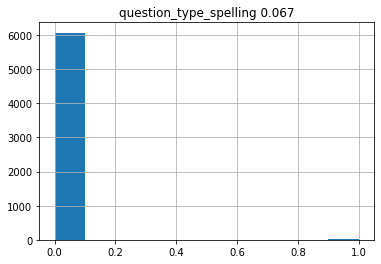

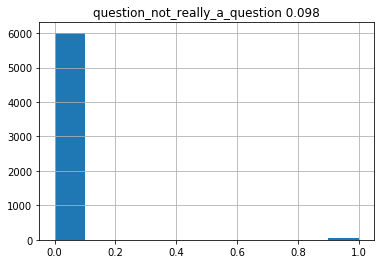

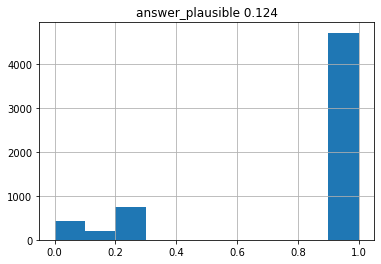

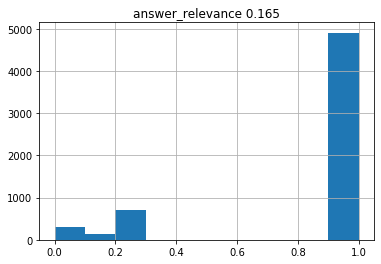

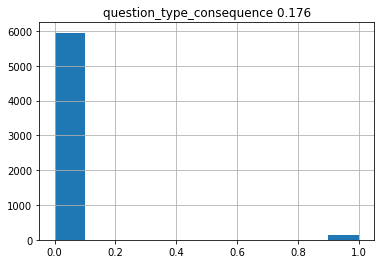

In [28]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


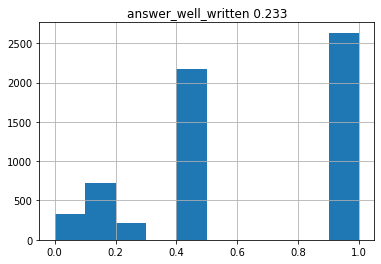

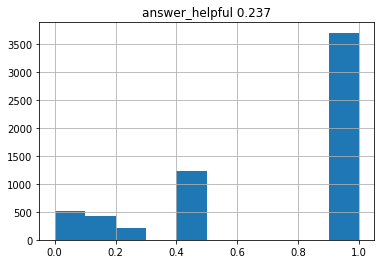

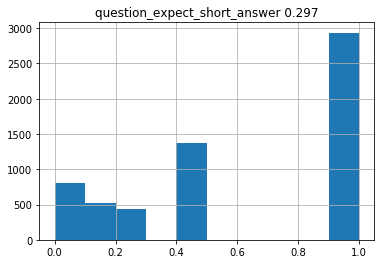

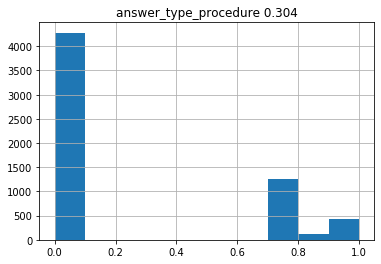

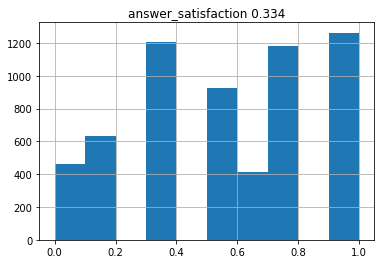

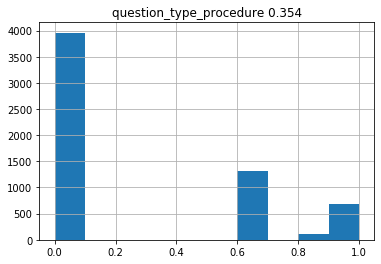

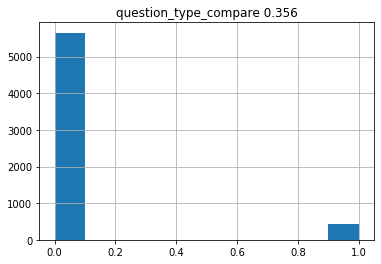

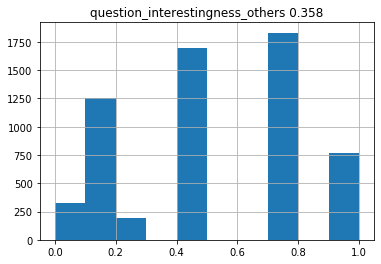

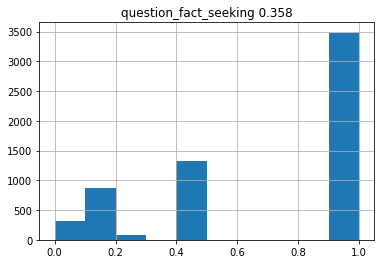

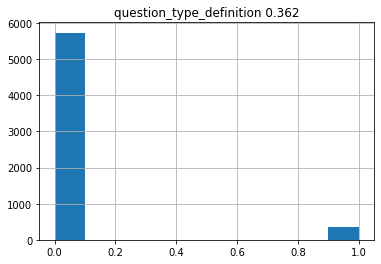

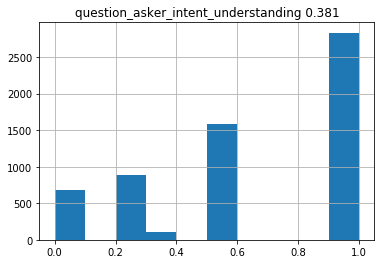

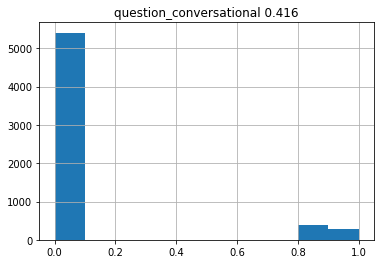

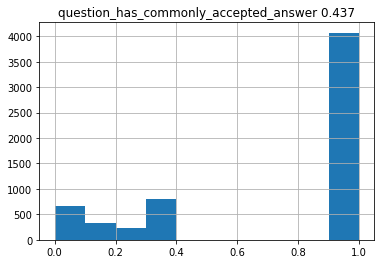

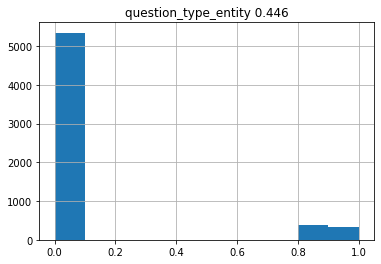

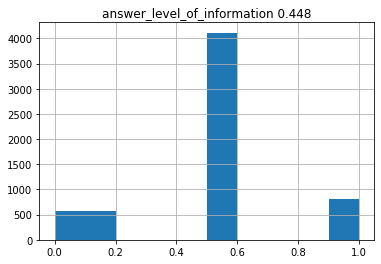

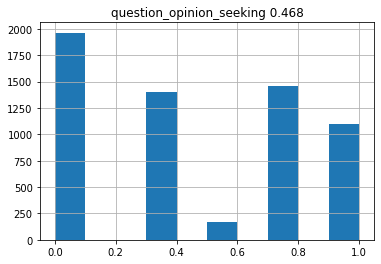

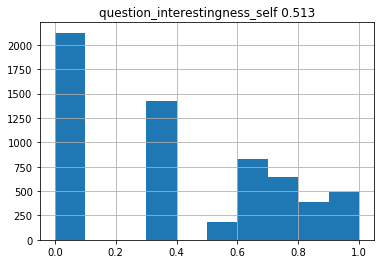

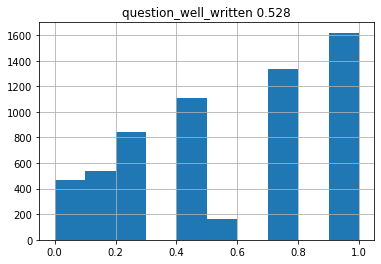

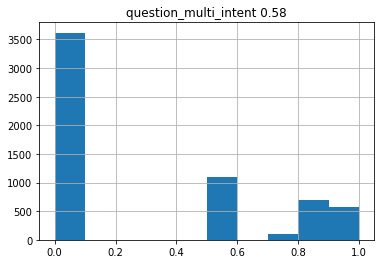

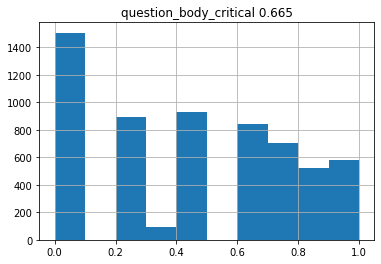

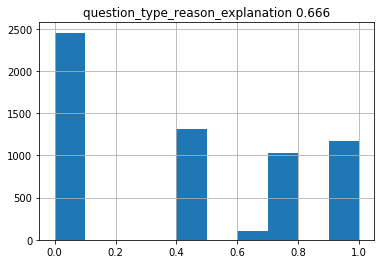

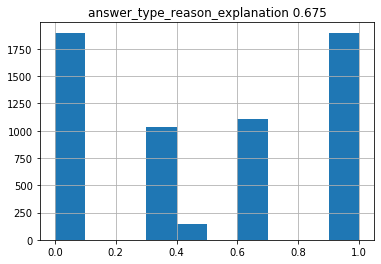

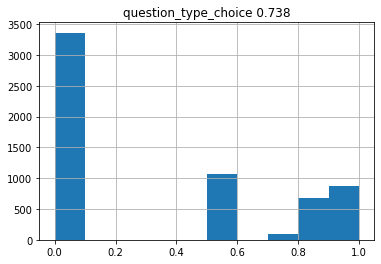

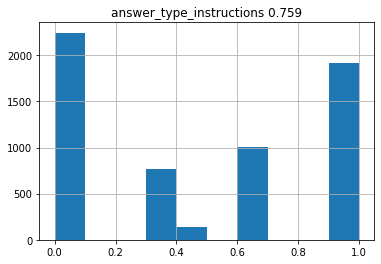

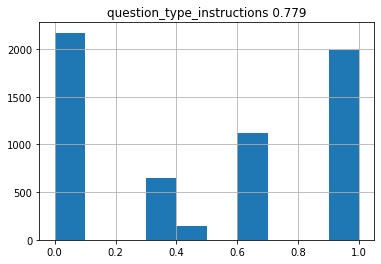

In [29]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')